**MOUNT GOOGLE DRIVE + IMPORT LIBRARIES**

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Set display options
plt.style.use("seaborn-v0_8-darkgrid")
pd.set_option("display.max_columns", 50)

print("✓ Libraries loaded and Google Drive mounted")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Libraries loaded and Google Drive mounted


**LOAD DATA FROM YOUR GOOGLE DRIVE**

In [3]:
# Your exact path
file_path = "/content/drive/MyDrive/Toronto_Property_Data/clean_combined_toronto_property_data.xlsx"

# Load the Excel file
df = pd.read_excel(file_path, sheet_name=0)

print(f"✓ Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head(5))


✓ Data loaded successfully!
Shape: (7324, 6)

First 5 rows:
    price    region                             address  bedrooms  bathrooms  \
0  799000  Ajax, ON           2 ROLLO DR, Ajax, Ontario         3          3   
1  989000  Ajax, ON  717 OLD HARWOOD AVE, Ajax, Ontario         2          1   
2  999900  Ajax, ON       52 ADDLEY CRES, Ajax, Ontario         3          4   
3  799900  Ajax, ON      249 MONARCH AVE, Ajax, Ontario         3          3   
4  899999  Ajax, ON         18 MONK CRES, Ajax, Ontario         3          3   

     pricem  
0  0.799000  
1  0.989000  
2  0.999900  
3  0.799900  
4  0.899999  


**DATA INSPECTION**

In [4]:
print("Data types and info:")
print(df.info())

print("\n" + "="*50)
print("Missing values:")
print(df.isnull().sum())

print("\n" + "="*50)
print("Summary statistics:")
print(df.describe())


Data types and info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7324 entries, 0 to 7323
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      7324 non-null   int64  
 1   region     7324 non-null   object 
 2   address    7324 non-null   object 
 3   bedrooms   7324 non-null   int64  
 4   bathrooms  7324 non-null   int64  
 5   pricem     7324 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 343.4+ KB
None

Missing values:
price        0
region       0
address      0
bedrooms     0
bathrooms    0
pricem       0
dtype: int64

Summary statistics:
              price     bedrooms    bathrooms       pricem
count  7.324000e+03  7324.000000  7324.000000  7324.000000
mean   1.444227e+06     3.062125     2.976106     1.444227
std    1.347525e+06     1.087886     1.401255     1.347525
min    3.590000e+05     0.000000     0.000000     0.359000
25%    7.997942e+05     2.000000     2.000000   

**DATA CLEANING**

In [6]:
# Drop missing critical columns
df_clean = df.dropna(subset=["price", "region"]).copy()
print(f"After removing missing: {df_clean.shape[0]} rows")

# Convert to numeric
df_clean["price"] = pd.to_numeric(df_clean["price"], errors="coerce")
df_clean["bedrooms"] = pd.to_numeric(df_clean["bedrooms"], errors="coerce")
df_clean["bathrooms"] = pd.to_numeric(df_clean["bathrooms"], errors="coerce")

# Drop bad prices
df_clean = df_clean.dropna(subset=["price"])
print(f"Final clean rows: {df_clean.shape[0]}")
print(f"\nPrice range: ${df_clean['price'].min():,.0f} - ${df_clean['price'].max():,.0f}")
print(f"Mean price: ${df_clean['price'].mean():,.0f}")


After removing missing: 7324 rows
Final clean rows: 7324

Price range: $359,000 - $27,975,000
Mean price: $1,444,227


**REMOVE OUTLIERS (IQR METHOD)**

In [7]:
Q1 = df_clean["price"].quantile(0.25)
Q3 = df_clean["price"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print(f"Lower bound: ${lower:,.0f}, Upper bound: ${upper:,.0f}")

before = df_clean.shape[0]
df_clean = df_clean[(df_clean["price"] >= lower) & (df_clean["price"] <= upper)]
removed = before - df_clean.shape[0]

print(f"Outliers removed: {removed}")
print(f"Final dataset: {df_clean.shape}")


Lower bound: $-400,513, Upper bound: $2,800,306
Outliers removed: 523
Final dataset: (6801, 6)


In [8]:
# Price bands
df_clean["price_band"] = pd.cut(
    df_clean["price"],
    bins=[0, 500_000, 1_000_000, 1_500_000, df_clean["price"].max()],
    labels=["<$500K", "$500K-$1M", "$1M-$1.5M", "$1.5M+"]
)

# Clean bedrooms/bathrooms
df_clean["bedrooms"] = df_clean["bedrooms"].fillna(0).astype(int)
df_clean["bathrooms"] = df_clean["bathrooms"].fillna(0).astype(int)

print("✓ Features engineered")
print("\nPrice band distribution:")
print(df_clean["price_band"].value_counts().sort_index())


✓ Features engineered

Price band distribution:
price_band
<$500K        220
$500K-$1M    3255
$1M-$1.5M    1799
$1.5M+       1527
Name: count, dtype: int64


In [9]:
print(f"Unique regions: {df_clean['region'].nunique()}")
print("\nTop 10 regions by AVERAGE PRICE:")

top10 = (
    df_clean.groupby("region")["price"]
    .agg(["mean", "count"])
    .sort_values("mean", ascending=False)
    .head(10)
)
top10.columns = ["Avg Price", "Count"]
print(top10)


Unique regions: 31

Top 10 regions by AVERAGE PRICE:
                               Avg Price  Count
region                                         
King, ON                    2.071096e+06     26
Caledon, ON                 1.629675e+06    100
Oakville, ON                1.601673e+06    331
East Gwillimbury, ON        1.576249e+06     77
Aurora, ON                  1.545415e+06    110
Richmond Hill, ON           1.539874e+06    319
Whitchurch-Stouffville, ON  1.428306e+06     80
Markham, ON                 1.386873e+06    432
Vaughan, ON                 1.371551e+06    423
Newmarket, ON               1.367995e+06    137


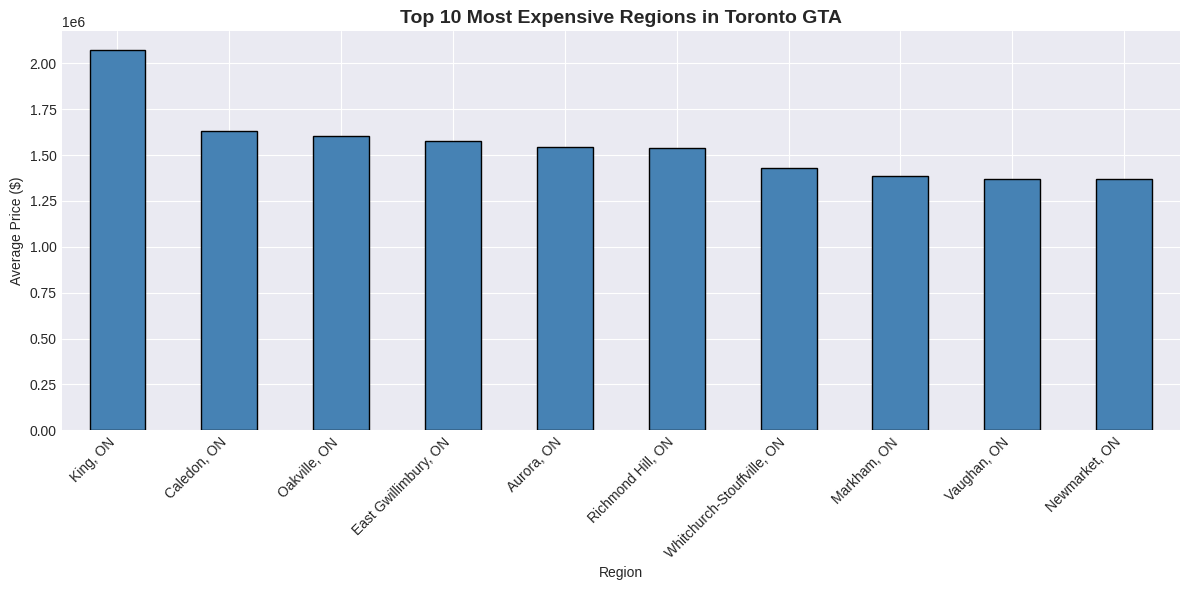

In [10]:
top10_price = (
    df_clean.groupby("region")["price"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 6))
top10_price.plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Top 10 Most Expensive Regions in Toronto GTA", fontsize=14, fontweight="bold")
plt.ylabel("Average Price ($)")
plt.xlabel("Region")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


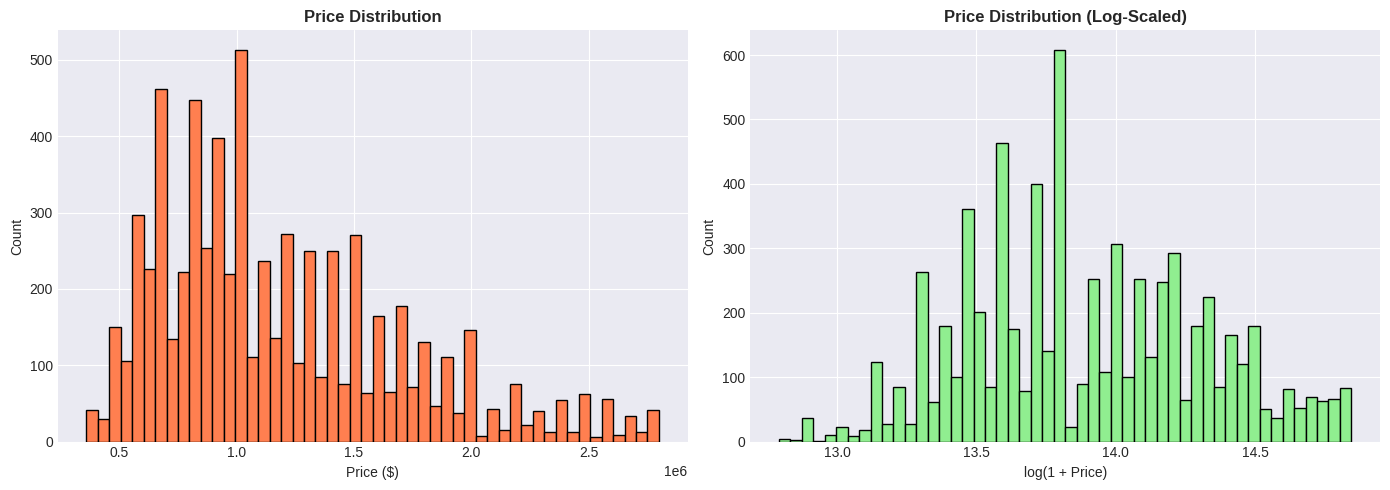

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard
axes[0].hist(df_clean["price"], bins=50, color="coral", edgecolor="black")
axes[0].set_title("Price Distribution", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Price ($)")
axes[0].set_ylabel("Count")

# Log-scaled
axes[1].hist(np.log1p(df_clean["price"]), bins=50, color="lightgreen", edgecolor="black")
axes[1].set_title("Price Distribution (Log-Scaled)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("log(1 + Price)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


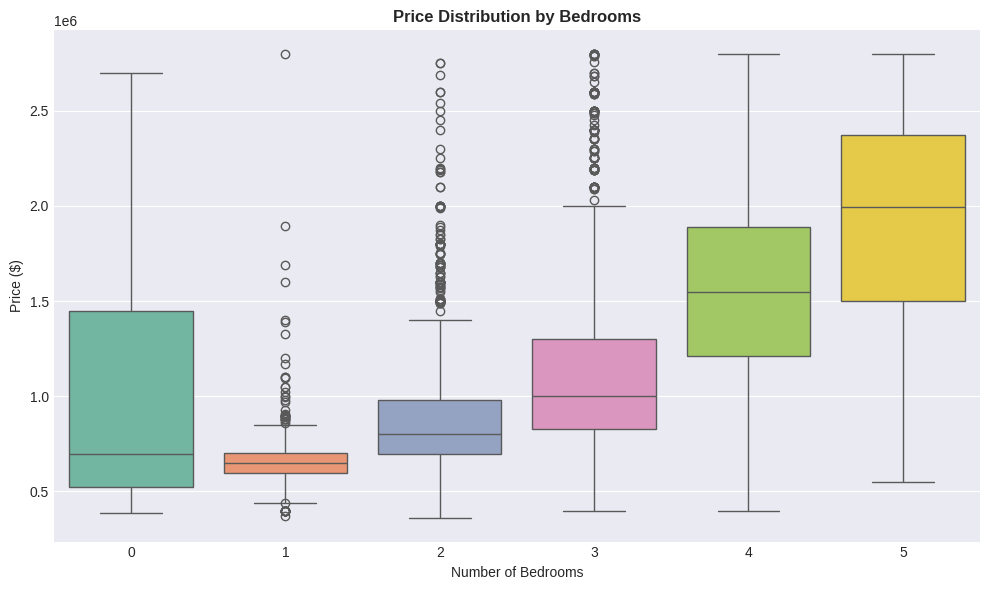

Bedroom price stats:
          count          mean     median
bedrooms                                
0            37  1.055492e+06   699000.0
1           602  6.607858e+05   649000.0
2          1176  8.908484e+05   799900.0
3          2963  1.102672e+06   999900.0
4          1759  1.582312e+06  1550000.0
5           218  1.895107e+06  1996500.0


In [12]:
df_plot = df_clean[df_clean["bedrooms"] <= 5]

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x="bedrooms", y="price", palette="Set2")
plt.title("Price Distribution by Bedrooms", fontsize=12, fontweight="bold")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()

print("Bedroom price stats:")
print(df_plot.groupby("bedrooms")["price"].agg(["count", "mean", "median"]))


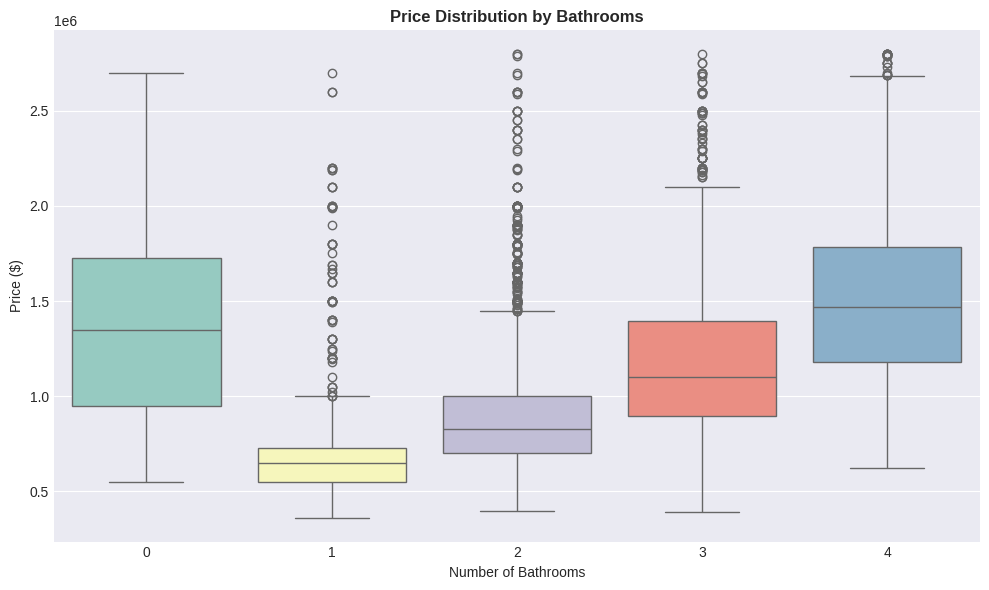

Bathroom price stats:
           count          mean     median
bathrooms                                
0             28  1.398539e+06  1349500.0
1            843  7.128005e+05   648800.0
2           2011  9.291466e+05   829000.0
3           1886  1.180051e+06  1099000.0
4           1582  1.508292e+06  1468000.0


In [13]:
df_plot = df_clean[df_clean["bathrooms"] <= 4]

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x="bathrooms", y="price", palette="Set3")
plt.title("Price Distribution by Bathrooms", fontsize=12, fontweight="bold")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Price ($)")
plt.tight_layout()
plt.show()

print("Bathroom price stats:")
print(df_plot.groupby("bathrooms")["price"].agg(["count", "mean", "median"]))


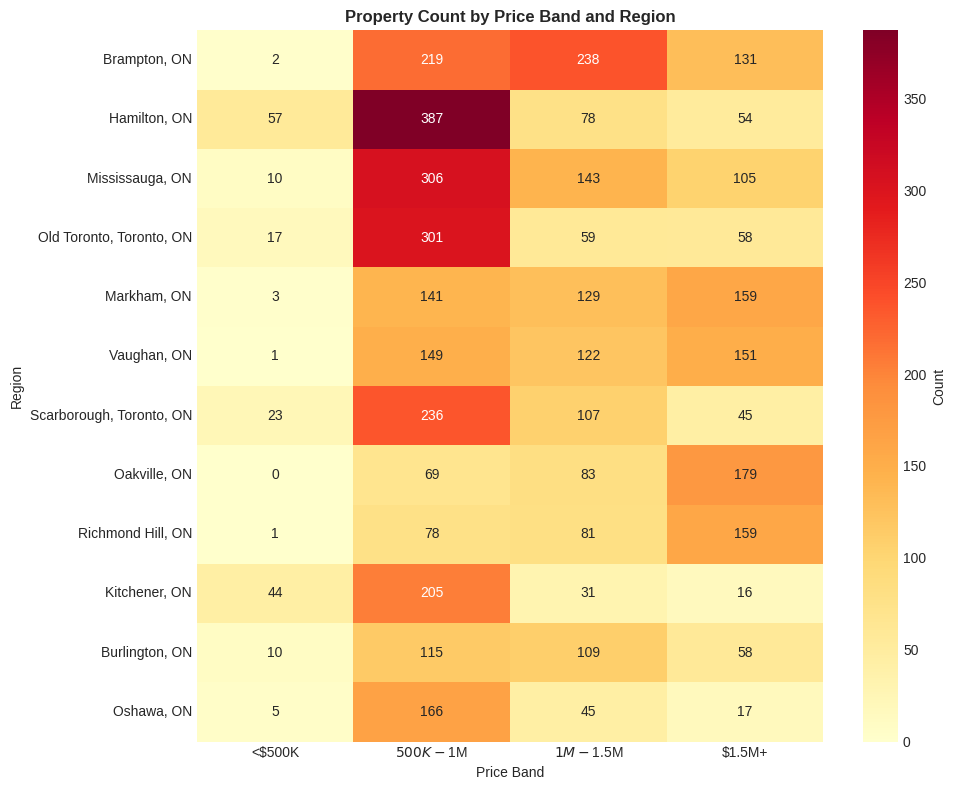

In [14]:
# Top 12 regions
pivot = pd.crosstab(df_clean["region"], df_clean["price_band"])
top_regions = df_clean["region"].value_counts().head(12).index
pivot_top = pivot.loc[top_regions]

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_top, annot=True, fmt="d", cmap="YlOrRd", cbar_kws={"label": "Count"})
plt.title("Property Count by Price Band and Region", fontsize=12, fontweight="bold")
plt.xlabel("Price Band")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


In [15]:
print("="*70)
print("TORONTO GTA REAL ESTATE ANALYSIS - KEY FINDINGS")
print("="*70)

print(f"\n1. OVERALL MARKET:")
print(f"   - Total properties: {df_clean.shape[0]:,}")
print(f"   - Price range: ${df_clean['price'].min():,.0f} to ${df_clean['price'].max():,.0f}")
print(f"   - Average price: ${df_clean['price'].mean():,.0f}")
print(f"   - Median price: ${df_clean['price'].median():,.0f}")

print(f"\n2. REGIONS:")
print(f"   - Total regions: {df_clean['region'].nunique()}")
most_expensive = df_clean.groupby("region")["price"].mean().idxmax()
most_expensive_price = df_clean.groupby("region")["price"].mean().max()
print(f"   - Most expensive: {most_expensive} (${most_expensive_price:,.0f} avg)")

print(f"\n3. PRICE BANDS:")
print(df_clean["price_band"].value_counts().sort_index())

print("\n" + "="*70)


TORONTO GTA REAL ESTATE ANALYSIS - KEY FINDINGS

1. OVERALL MARKET:
   - Total properties: 6,801
   - Price range: $359,000 to $2,800,000
   - Average price: $1,180,849
   - Median price: $999,990

2. REGIONS:
   - Total regions: 31
   - Most expensive: King, ON ($2,071,096 avg)

3. PRICE BANDS:
price_band
<$500K        220
$500K-$1M    3255
$1M-$1.5M    1799
$1.5M+       1527
Name: count, dtype: int64

